# DS CA7

Written by Parsa Ahmadi 810101609, Mahdi Naeini 810101536 and Babak Hosseini Mohtasham 810101408

# Imports

In [125]:
from wordcloud import WordCloud, STOPWORDS
import accelerate
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import LabelPropagation,SelfTrainingClassifier,LabelSpreading
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from scipy.stats import distributions
from scipy import stats
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
import xgboost as xgb
random_state=42

# EDA

In [126]:
train_validation=pd.read_json('train_imdb.jsonl',lines=True)
aug=pd.read_json('aug_imdb_unlabeled.jsonl',lines=True)
test=pd.read_json('test_imdb.jsonl',lines=True)

In [127]:
train,validation=train_test_split(train_validation,train_size=0.8,random_state=random_state)

In [128]:
train_validation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       150 non-null    object
 1   label      150 non-null    int64 
 2   embedding  150 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.7+ KB


In [129]:
train_validation.describe()

,label
count,150.000000
mean,0.553333
std,0.498813
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [130]:
aug.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1014 entries, 0 to 1013
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       1014 non-null   object
 1   embedding  1014 non-null   object
dtypes: object(2)
memory usage: 23.8+ KB


In [131]:
aug.describe()

,text,embedding
count,1014,1014
unique,1014,1014
top,there is no relation at all between fortier an...,"[-0.09757755700000001, -0.1536363065, 0.311417..."
freq,1,1


In [132]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       150 non-null    object
 1   label      150 non-null    int64 
 2   embedding  150 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.7+ KB


In [133]:
test.describe()

,label
count,150.000000
mean,0.480000
std,0.501274
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [134]:
train_validation_aug=pd.concat([train_validation,aug],ignore_index=True)
train_validation_aug['length']=train_validation_aug['text'].str.len()
train_validation_aug.describe()

,label,length
count,150.000000,1164.000000
mean,0.553333,529.162371
std,0.498813,162.187296
min,0.000000,70.000000
25%,0.000000,392.000000
50%,1.000000,580.000000
75%,1.000000,662.000000
max,1.000000,891.000000


In [135]:
def plot_hist(df,col):
  df[col].plot(kind='hist', bins=20, title=col)
  plt.gca().spines[['top', 'right',]].set_visible(False)

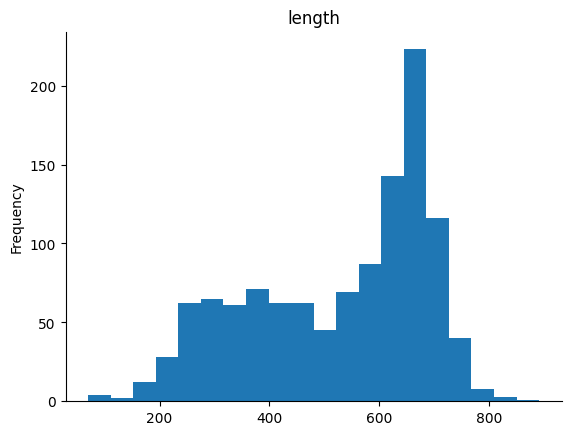

In [136]:
plot_hist(train_validation_aug,'length')

In [137]:
train_validation_aug['word count']=train_validation_aug['text'].apply(lambda x: len(x.split()))
train_validation_aug.describe()

,label,length,word count
count,150.000000,1164.000000,1164.000000
mean,0.553333,529.162371,94.008591
std,0.498813,162.187296,28.075992
min,0.000000,70.000000,12.000000
25%,0.000000,392.000000,72.000000
50%,1.000000,580.000000,103.000000
75%,1.000000,662.000000,119.000000
max,1.000000,891.000000,128.000000


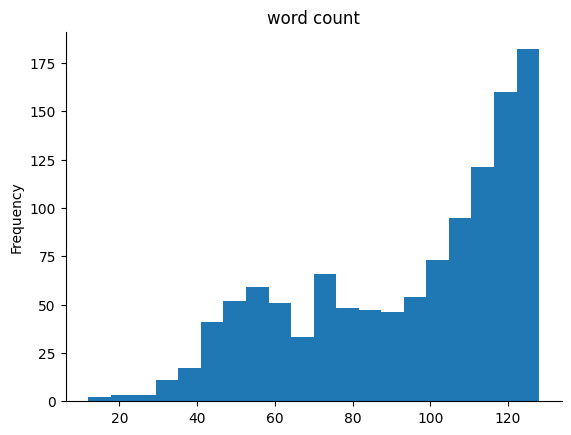

In [138]:
plot_hist(train_validation_aug,'word count')

In [139]:
train_validation_aug['mean word length']=train_validation_aug['text'].apply(lambda x: np.mean([len(c) for c in x.split()]))
train_validation_aug.describe()

,label,length,word count,mean word length
count,150.000000,1164.000000,1164.000000,1164.000000
mean,0.553333,529.162371,94.008591,4.641433
std,0.498813,162.187296,28.075992,0.397687
min,0.000000,70.000000,12.000000,3.432836
25%,0.000000,392.000000,72.000000,4.368581
50%,1.000000,580.000000,103.000000,4.622344
75%,1.000000,662.000000,119.000000,4.889323
max,1.000000,891.000000,128.000000,6.333333


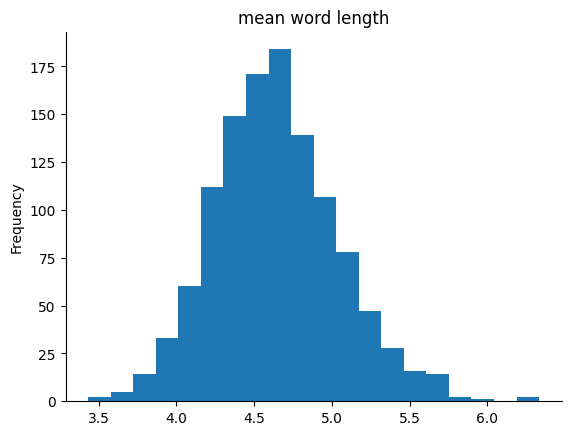

In [140]:
plot_hist(train_validation_aug,'mean word length')

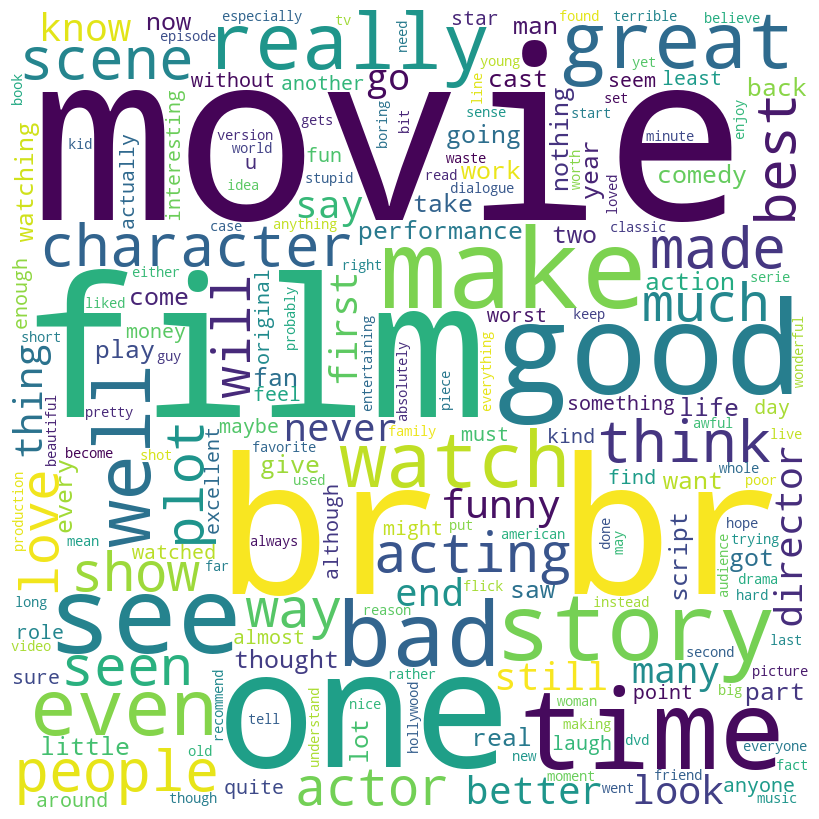

In [141]:
comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in train_validation_aug['text']:

	# typecaste each val to string
	val = str(val)

	# split the value
	tokens = val.split()

	# Converts each token into lowercase
	for i in range(len(tokens)):
		tokens[i] = tokens[i].lower()

	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
				background_color ='white',
				stopwords = stopwords,
				min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

# Feature Engineering

Methods for extracting features from text data:
* **Bag-of-words**: The bag-of-words model is a simple but effective feature extraction technique that counts the number of occurrences of each word in a document. This can be used to create a feature vector that represents the document.
* **N-grams**: N-grams are sequences of n words. N-grams can be used to create feature vectors that represent the order of words in a document.
* **TF-IDF**: TF-IDF stands for term frequency-inverse document frequency. TF-IDF is a weighting scheme that can be used to measure the importance of a word in a document.
* **Word embeddings**: Word embeddings are learned representations of words that capture the meaning of the words. Word embeddings can be used to create feature vectors that represent the meaning of words in a document.

# Semi-Supervised

## Using Traditional Methods (Label Propagation)

### Label Propagation Techniques

Label propagation techniques leverage the structure of the data to spread the labels from labeled to unlabeled points. The underlying assumption is that points that are close to each other or share some structural similarity are likely to have the same label. Key label propagation techniques include:

1. **Classic Label Propagation (LP):**
   - **Graph Construction:** Construct a graph where each node represents a data point and edges represent the similarity or distance between points.
   - **Initialization:** Initialize the labels of the labeled nodes and set the labels of the unlabeled nodes to a default value (often zero or some neutral value).
   - **Propagation:** Iteratively update the label of each node based on the labels of its neighbors. The process continues until convergence, i.e., when labels stop changing significantly.
   - **Final Assignment:** Assign labels to the unlabeled nodes based on the propagated labels.

2. **Label Spreading:**
   - Similar to label propagation but employs a normalized version of the propagation step to ensure the label distribution spreads more smoothly across the graph.
   - Emphasizes local consistency by incorporating both the label distribution of neighboring nodes and the original label information.

### Traditional Methods in Label Propagation

Traditional clustering methods like KMeans can be integrated into label propagation techniques to enhance the performance and efficiency. Here’s how KMeans and other traditional methods are used:

1. **KMeans Clustering:**
   - **Initial Clustering:** Apply KMeans clustering to the entire dataset (both labeled and unlabeled points) to form clusters.
   - **Cluster Labeling:** Assign labels to each cluster based on the majority label of the labeled points within the cluster. This step assumes that each cluster predominantly contains points of a single class.
   - **Label Propagation:** Use the cluster labels as initial labels for the label propagation algorithm, which then refines these labels by considering the local structure of the data.

2. **Graph-Based Methods:**
   - **K-Nearest Neighbors (KNN):** Construct a graph using KNN, where each node is connected to its k-nearest neighbors. The edges are weighted based on the distance or similarity between points.
   - **Graph Construction with KMeans:** Use KMeans to form clusters and then create a graph where nodes represent cluster centroids. This reduces the graph size and computational complexity.

3. **Spectral Clustering:**
   - **Graph Construction:** Construct a similarity graph and compute its Laplacian matrix.
   - **Eigen Decomposition:** Perform eigen decomposition on the Laplacian matrix to obtain a low-dimensional representation of the data.
   - **Clustering and Propagation:** Use a clustering algorithm (like KMeans) on the low-dimensional representation and propagate labels based on the cluster assignments.

### Advantages and Challenges

**Advantages:**
- **Efficiency:** Utilizing clustering methods like KMeans can significantly reduce the computational complexity by working on a reduced representation of the data.
- **Improved Accuracy:** Label propagation can improve the classification accuracy by leveraging the inherent structure of the data.
- **Scalability:** These techniques can handle large datasets effectively by combining graph-based methods with clustering algorithms.

**Challenges:**
- **Parameter Sensitivity:** The performance of label propagation methods can be sensitive to the choice of parameters, such as the number of clusters in KMeans or the number of neighbors in KNN.
- **Graph Construction:** Constructing a meaningful and efficient graph that accurately captures the data structure is crucial and can be computationally expensive.
- **Imbalanced Labels:** If the labeled data is not representative or is imbalanced, the propagated labels may not accurately reflect the true distribution of classes.

In summary, label propagation techniques in semi-supervised learning leverage the structure of the data to spread labels from a small labeled set to a larger unlabeled set. Traditional methods like KMeans can be integrated to enhance the efficiency and effectiveness of these techniques. However, careful consideration of parameters and graph construction is essential to achieve optimal performance.

In [142]:
class LabelPropagator():
    def get_array_values_from_df(self,df):
        return np.array([val for val in df])

    def _propagate(self,X_train,y_train,aug,thresh):
        X_train=self.get_array_values_from_df(X_train)
        X_aug=self.get_array_values_from_df(aug)
        X_aug,y_aug=self._get_labeled_aug(X_train,y_train,X_aug,thresh)
        return X_train,y_train,X_aug,y_aug

    def _get_labeled_aug(self,aug,thresh):
        pass

In [143]:
class MyLabelPropagator(LabelPropagator):
    def label_propagate(self,X_train,y_train,aug,k,thresh):
        self.model=KNeighborsClassifier(n_neighbors=k)
        X_train,y_train,X_aug,y_aug=self._propagate(X_train,y_train,aug,thresh)
        return np.concatenate([X_train,X_aug]),np.concatenate([y_train,y_aug])
    
    def _get_labeled_aug(self,X_train,y_train,aug,thresh):
        self.model.fit(X_train,y_train)
        predictions=self.model.predict(aug)
        predictions_accuracy=self.model.predict_proba(aug)
        X_aug=[]
        y_aug=[]
        for i,pred in enumerate(predictions):
            if (predictions_accuracy[i]).max()>thresh:
                X_aug.append(aug[i])
                y_aug.append(pred)
        return X_aug,y_aug

In [144]:
class SKLearnLabelPropagator(LabelPropagator):
    def label_propagate(self,X_train,y_train,aug,k,thresh=0.5):
        self.model=LabelPropagation(n_neighbors=k)
        X_train,y_train,X_aug,y_aug=self._propagate(X_train,y_train,aug,thresh)
        return np.concatenate([X_train,X_aug]),np.concatenate([y_train,y_aug])
    
    def _get_labeled_aug(self,X_train,y_train,aug,thresh):
        X=np.concatenate([X_train,aug])
        y=np.concatenate([y_train,np.full(len(aug),-1)])
        self.model.fit(X,y)
        y=self.model.transduction_
        return aug,y[len(y_train):]

In [145]:
class SKLearnLabelSpreading(LabelPropagator):
    def label_propagate(self,X_train,y_train,aug,k,thresh=0.5):
        self.model=LabelSpreading(n_neighbors=k)
        X_train,y_train,X_aug,y_aug=self._propagate(X_train,y_train,aug,thresh)
        return np.concatenate([X_train,X_aug]),np.concatenate([y_train,y_aug])
    
    def _get_labeled_aug(self,X_train,y_train,aug,thresh):
        X=np.concatenate([X_train,aug])
        y=np.concatenate([y_train,np.full(len(aug),-1)])
        self.model.fit(X,y)
        y=self.model.transduction_
        return aug,y[len(y_train):]

In [146]:
my_propagator=MyLabelPropagator()
X_validation=my_propagator.get_array_values_from_df(validation['embedding'])
y_validation=my_propagator.get_array_values_from_df(validation['label'])
X_train=[0]*9
y_train=[0]*9
X_train[0],y_train[0]=my_propagator.label_propagate(train['embedding'],train['label']
                                                                                    ,aug['embedding'],3,0.7)
X_train[1],y_train[1]=my_propagator.label_propagate(train['embedding'],train['label']
                                                                                    ,aug['embedding'],9,0.9)
X_train[2],y_train[2]=my_propagator.label_propagate(train['embedding'],train['label']
                                                                                    ,aug['embedding'],19,0.5)

In [147]:
label_propagator=SKLearnLabelPropagator()
X_train[3],y_train[3]=label_propagator.label_propagate(train['embedding'],train['label']
                                                                                    ,aug['embedding'],5)
X_train[4],y_train[4]=label_propagator.label_propagate(train['embedding'],train['label']
                                                                                    ,aug['embedding'],7)
X_train[5],y_train[5]=label_propagator.label_propagate(train['embedding'],train['label']
                                                                                    ,aug['embedding'],11)

In [148]:
label_spreader=SKLearnLabelSpreading()
X_train[6],y_train[6]=label_spreader.label_propagate(train['embedding'],train['label']
                                                                                    ,aug['embedding'],13)
X_train[7],y_train[7]=label_spreader.label_propagate(train['embedding'],train['label']
                                                                                    ,aug['embedding'],15)
X_train[8],y_train[8]=label_spreader.label_propagate(train['embedding'],train['label']
                                                                                    ,aug['embedding'],17)

In [162]:
class MyClassifier:
    def report_scores(self, predicted_values, actual_values):
        print(f"Accuracy: {round(accuracy_score(actual_values,predicted_values),3)}")
        print(f"Recall: Micro: {round(recall_score(actual_values,predicted_values,average='micro'),3)}"+
                              f" Macro: {round(recall_score(actual_values,predicted_values,average='macro'),3)}"+
                              f" Weighted: {round(recall_score(actual_values,predicted_values,average='weighted'),3)}")
        print(f"Precision: Micro: {round(precision_score(actual_values,predicted_values,average='micro'),3)}"+
            f" Macro: {round(precision_score(actual_values,predicted_values,average='macro'),3)}"+
            f" Weighted: {round(precision_score(actual_values,predicted_values,average='weighted'),3)}")
        print(f"F1 score: Micro: {round(f1_score(actual_values,predicted_values,average='micro'),3)}"+
            f" Macro: {round(f1_score(actual_values,predicted_values,average='macro'),3)}"+
            f" Weighted: {round(f1_score(actual_values,predicted_values,average='weighted'),3)}")
        matrix=confusion_matrix(actual_values,predicted_values)
        sns.heatmap(matrix, annot=True, cmap="flare")

    def fit(self,X, y):
        self.model.fit(X,y)

    def predict(self,X):
        return self.model.predict(X)
    
    def fit_predict_report(self,X_train,y_train,X_test,y_test):
        self.fit(X_train,y_train)
        predictions = self.predict(X_test)
        self.report_scores(predictions, y_test)

    def randomized_search_params(self,param_distributions, X, y,n_iter=10):
        return RandomizedSearchCV(self.model, param_distributions=param_distributions,n_iter=n_iter).fit(X, y)

In [163]:
class MyKNNClassifier(MyClassifier):
    def __init__(self) -> None:
        super().__init__()
        self.model = KNeighborsClassifier()
    def set_params(self, params):
        self.model = KNeighborsClassifier(n_neighbors=params['n_neighbors'],metric=params['metric'])

In [169]:
def report_best_scores_from_labels(X_train,y_train,X_test,y_test,model,params,n_iter=10):
    best_score=0
    best_params=None
    best_i=0
    for i in range(len(X_train)):
        search = model.randomized_search_params(params,X_train[i], y_train[i],n_iter=n_iter)
        if search.best_score_>best_score:
            best_score=search.best_score_
            best_params=search.best_params_
            best_i=i
    print(f'The {i}th train set got the best results')
    model.set_params(best_params)
    model.fit_predict_report(X_train[best_i], y_train[best_i],X_test,y_test)

The 8th train set got the best results
Accuracy: 0.733
Recall: Micro: 0.733 Macro: 0.746 Weighted: 0.733
Precision: Micro: 0.733 Macro: 0.71 Weighted: 0.779
F1 score: Micro: 0.733 Macro: 0.713 Weighted: 0.744


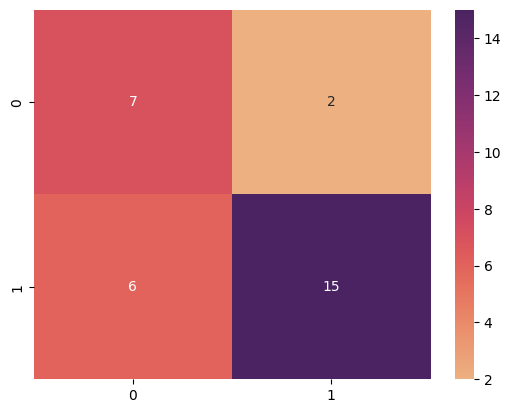

In [165]:
KNN_model=MyKNNClassifier()
KNN_params={'n_neighbors': np.arange(1, 10),
    'metric': ['euclidean', 'l1', 'minkowski', 'hamming',
                'l2', 'p', 'infinity', 'cityblock',
                  'sqeuclidean', 'braycurtis', 'correlation', 'cosine',
                    'nan_euclidean', 'manhattan', 'chebyshev', 'canberra']}
report_best_scores_from_labels(X_train,y_train,X_validation,y_validation,KNN_model,KNN_params)

In [166]:
class MyRandomForestClassifier(MyClassifier):
    def __init__(self, random_state) -> None:
        super().__init__()
        self.model = RandomForestClassifier(oob_score=False, n_jobs=-1,random_state=random_state)
        self.random_state=random_state

    def set_params(self, params) -> None:
        self.model = RandomForestClassifier(oob_score=False,n_jobs=-1,n_estimators=params['n_estimators'],
                                            max_features=params['max_features'], 
                                            min_samples_leaf=params['min_samples_leaf'],random_state=self.random_state)
        
    def plot_feature_importance(self, columns) -> None:
        plt.figure(figsize=(8, 6))
        plt.bar(columns, self.model.feature_importances_)
        plt.show()

8
Accuracy: 0.8
Recall: Micro: 0.8 Macro: 0.794 Weighted: 0.8
Precision: Micro: 0.8 Macro: 0.766 Weighted: 0.817
F1 score: Micro: 0.8 Macro: 0.775 Weighted: 0.805


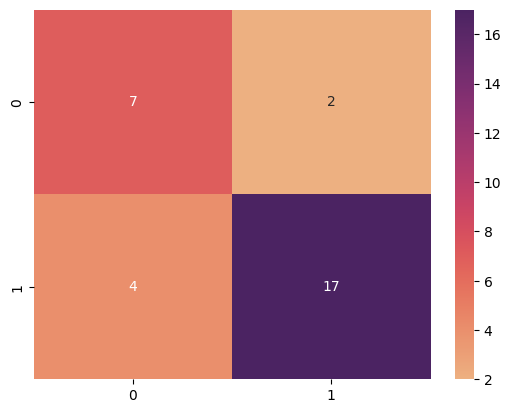

In [157]:
random_forest_model=MyRandomForestClassifier(random_state)
random_forest_params={'n_estimators': np.arange(70, 101, 20),
     'max_features': np.arange(7, 12),
     'min_samples_leaf': np.arange(1, 5)}
report_best_scores_from_labels(X_train,y_train,X_validation,y_validation,random_forest_model,random_forest_params)

In [167]:
class MyXGBoostClassifier(MyClassifier):
    def __init__(self, random_state) -> None:
        super().__init__()
        self.model = xgb.XGBClassifier(random_state=random_state)
        self.random_state=random_state

    def set_params(self, params) -> None:
        self.model = xgb.XGBClassifier(
            learning_rate=params['learning_rate'], max_depth=params['max_depth'], 
            min_child_weight=params['min_child_weight'], colsample_bytree=params['colsample_bytree'],
            n_estimators=params['n_estimators'],random_state=self.random_state)

    def plot_feature_importance(self, columns) -> None:
        plt.figure(figsize=(8, 6))
        plt.bar(columns, self.model.feature_importances_)
        plt.show()

The 8th train set got the best results
Accuracy: 0.833
Recall: Micro: 0.833 Macro: 0.786 Weighted: 0.833
Precision: Micro: 0.833 Macro: 0.807 Weighted: 0.83
F1 score: Micro: 0.833 Macro: 0.795 Weighted: 0.83


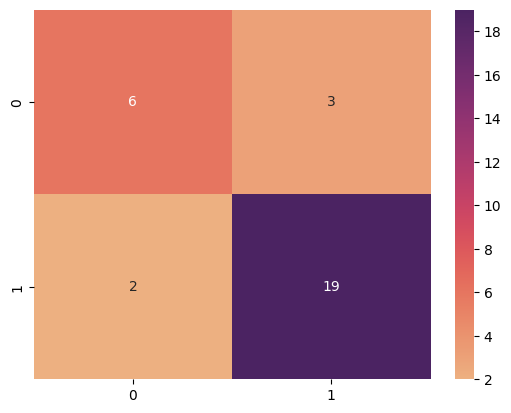

In [170]:
XGBoost_model = MyXGBoostClassifier(random_state)
XGBoost_params = {"learning_rate": stats.distributions.uniform(loc=0.5, scale=0.5),
     "max_depth": stats.randint(1, 100), "min_child_weight": stats.randint(1, 100), 
     "colsample_bytree": stats.distributions.uniform(loc=0.5, scale=0.5), "n_estimators": stats.randint(1, 1000)}
report_best_scores_from_labels(X_train,y_train,X_validation,y_validation,XGBoost_model,XGBoost_params,n_iter=2)

In [175]:
class MySVMClassifier(MyClassifier):
    def __init__(self) -> None:
        super().__init__()
        self.model = SVC()

    def set_params(self,params):
        self.model = SVC(kernel=params['kernel'],C=params['C'], degree=params['degree'])

The 8th train set got the best results
Accuracy: 0.833
Recall: Micro: 0.833 Macro: 0.786 Weighted: 0.833
Precision: Micro: 0.833 Macro: 0.807 Weighted: 0.83
F1 score: Micro: 0.833 Macro: 0.795 Weighted: 0.83


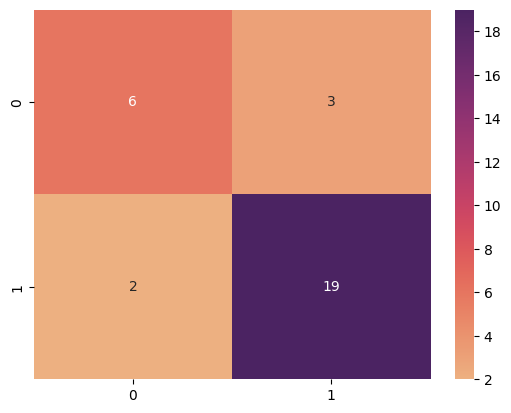

In [176]:
SVM_model = MySVMClassifier()
SVM_params = {'kernel':['linear','rbf'],'C': stats.distributions.uniform(loc=100, scale=1000),'degree': stats.randint(1, 100)}
report_best_scores_from_labels(X_train,y_train,X_validation,y_validation,SVM_model,SVM_params)

Accuracy: 0.673
Recall: Micro: 0.673 Macro: 0.673 Weighted: 0.673
Precision: Micro: 0.673 Macro: 0.673 Weighted: 0.673
F1 score: Micro: 0.673 Macro: 0.673 Weighted: 0.673


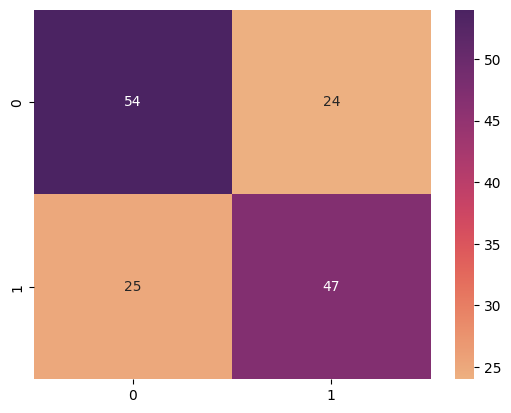

In [191]:
X_train_validation=np.concatenate((X_train[8],X_validation))
y_train_validation=np.concatenate((y_train[8],y_validation))
X_test=my_propagator.get_array_values_from_df(test['embedding'])
y_test=my_propagator.get_array_values_from_df(test['label'])
SVM_model.fit_predict_report(X_train_validation,y_train_validation,X_test,y_test)

Accuracy: 0.74
Recall: Micro: 0.74 Macro: 0.74 Weighted: 0.74
Precision: Micro: 0.74 Macro: 0.74 Weighted: 0.741
F1 score: Micro: 0.74 Macro: 0.74 Weighted: 0.74


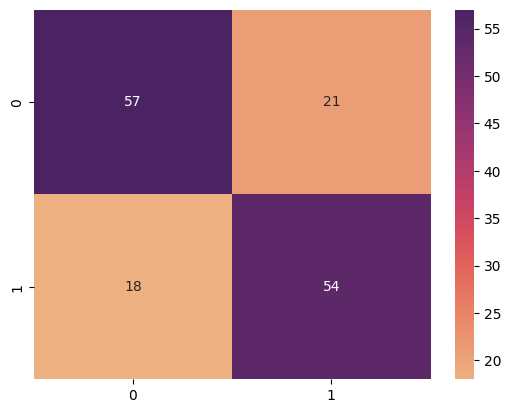

In [192]:
original_X_train=my_propagator.get_array_values_from_df(train['embedding'])
original_y_train=my_propagator.get_array_values_from_df(train['label'])
SVM_model.fit_predict_report(original_X_train,original_y_train,X_test,y_test)

## Using LLMs

### Load model

In [205]:
MODEL_ARGS = {
    'Name': 'microsoft/Phi-3-mini-128k-instruct',
    'DType': torch.bfloat16 # add torch.
}
device = "cuda" if torch.cuda.is_available() else "cpu"

In [206]:
def load_model(model_args):


    model = AutoModelForCausalLM.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
        torch_dtype=model_args['DType'], #remove torch.
        low_cpu_mem_usage=True,
        device_map={"": device},
    )
    tokenizer = AutoTokenizer.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
    )

    return model, tokenizer

In [207]:
model, tokenizer = load_model(MODEL_ARGS)

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


ImportError: This modeling file requires the following packages that were not found in your environment: flash_attn. Run `pip install flash_attn`

In [ ]:
def generate_text(model, tokenizer, prompt, max_new_tokens = 100, do_sample=True, temperature=0.5):

    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    if do_sample:
        output_ids = model.generate(input_ids, max_new_tokens=max_new_tokens, do_sample=True, temperature=temperature)
    else:
        output_ids = model.generate(input_ids, max_new_tokens=max_new_tokens, do_sample=do_sample)

    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return output_text[len(prompt):]

In [211]:
train_prompt = [f"""Question: I have a data set consisted of the comments people about movies in IMDB website. The comments are either positive if the person likes the movie or negative if they don't like it. Most texts have a label if the comment is positive the label is 1 else it is 0 Its your task  to classify the comments that are missing their label. What is the label of this comment: {text}
Answer: {train['label'].values[i]}""" for i,text in enumerate(train['text'].values[:1])]

In [212]:
validation_prompt=[f"""Question: I have a data set consisted of the comments people about movies in IMDB website. The comments are either positive if the person likes the movie or negative if they don't like it. Most texts have a label if the comment is positive the label is 1 else it is 0 Its your task  to classify the comments that are missing their label. What is the label of this comment: {text}
Answer:""" for i,text in enumerate(validation['text'].values[:1])]

In [ ]:
prompt = '\n'.join(train_prompt)+'\n'+'\n'.join(validation_prompt)+'\n'+'"""Answer:"""'

generate_text(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    max_new_tokens=200,
    temperature=1.2,
)

# References

https://www.linkedin.com/pulse/feature-extraction-natural-language-processing-vivekanandan
https://medium.com/@eskandar.sahel/exploring-feature-extraction-techniques-for-natural-language-processing-46052ee6514
https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data
https://www.altexsoft.com/blog/semi-supervised-learning